In [1]:
from collections import Counter, defaultdict
from functools import partial, reduce
from linear_algebra import shape, get_row, get_column, make_matrix, \
    vector_mean, vector_sum, dot, magnitude, vector_subtract, scalar_multiply
from stats import correlation, standard_deviation, mean
from probability import inverse_normal_cdf
from gradient_descent import maximize_batch
import math, random, csv
import matplotlib.pyplot as plt
import dateutil.parser

%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
def bucketize(point, bucket_size):
    """floor the point to the next lower multiple of bucket_size"""
    return bucket_size * math.floor(point / bucket_size)

def make_histogram(points, bucket_size):
    """buckets the points and counts how many in each bucket"""
    return Counter(bucketize(point, bucket_size) for point in points)

def plot_histogram(points, bucket_size, title=""):
    histogram = make_histogram(points, bucket_size)
    plt.bar(histogram.keys(), histogram.values(), width=bucket_size)
    plt.title(title)
    plt.show()

def compare_two_distributions():

    random.seed(0)

    uniform = [random.randint(-100,101) for _ in range(200)]
    normal = [57 * inverse_normal_cdf(random.random())
              for _ in range(200)]

    plot_histogram(uniform, 10, "Uniform Histogram")
    plot_histogram(normal, 10, "Normal Histogram")

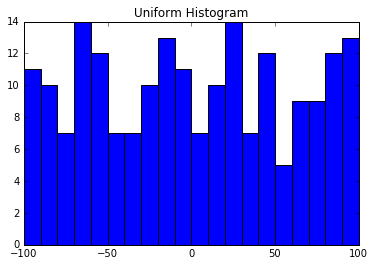

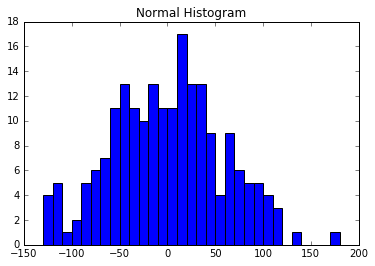

In [3]:
compare_two_distributions()

In [4]:
def random_normal():
    """returns a random draw from a standard normal distribution"""
    return inverse_normal_cdf(random.random())

xs = [random_normal() for _ in range(1000)]
ys1 = [ x + random_normal() / 2 for x in xs]
ys2 = [-x + random_normal() / 2 for x in xs]


def scatter():
    plt.scatter(xs, ys1, marker='.', color='black', label='ys1')
    plt.scatter(xs, ys2, marker='.', color='gray',  label='ys2')
    plt.xlabel('xs')
    plt.ylabel('ys')
    plt.legend(loc=9)
    plt.show()

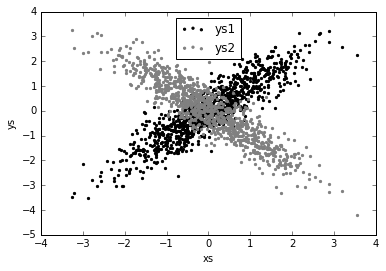

In [5]:
scatter()

In [6]:
correlation(xs,ys1)

0.8973760231027484

In [7]:
correlation(xs,ys2)

-0.9033393123522656

In [8]:
def correlation_matrix(data):
    """returns the num_columns x num_columns matrix whose (i, j)th entry
    is the correlation between columns i and j of data"""

    _, num_columns = shape(data)

    def matrix_entry(i, j):
        return correlation(get_column(data, i), get_column(data, j))

    return make_matrix(num_columns, num_columns, matrix_entry)

In [9]:
def make_scatterplot_matrix():

    # first, generate some random data

    num_points = 100

    def random_row():
        row = [None, None, None, None]
        row[0] = random_normal()
        row[1] = -5 * row[0] + random_normal()
        row[2] = row[0] + row[1] + 5 * random_normal()
        row[3] = 6 if row[2] > -2 else 0
        return row
    random.seed(0)
    data = [random_row()
            for _ in range(num_points)]

    # then plot it

    _, num_columns = shape(data)
    fig, ax = plt.subplots(num_columns, num_columns)

    for i in range(num_columns):
        for j in range(num_columns):

            # scatter column_j on the x-axis vs column_i on the y-axis
            if i != j: ax[i][j].scatter(get_column(data, j), get_column(data, i))

            # unless i == j, in which case show the series name
            else: ax[i][j].annotate("series " + str(i), (0.5, 0.5),
                                    xycoords='axes fraction',
                                    ha="center", va="center")

            # then hide axis labels except left and bottom charts
            if i < num_columns - 1: ax[i][j].xaxis.set_visible(False)
            if j > 0: ax[i][j].yaxis.set_visible(False)

    # fix the bottom right and top left axis labels, which are wrong because
    # their charts only have text in them
    ax[-1][-1].set_xlim(ax[0][-1].get_xlim())
    ax[0][0].set_ylim(ax[0][1].get_ylim())

    plt.show()

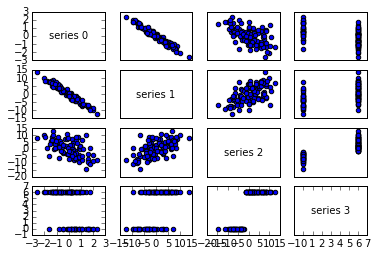

In [10]:
make_scatterplot_matrix()

In [11]:
def parse_row(input_row, parsers):
    """given a list of parsers (some of which may be None)
    apply the appropriate one to each element of the input_row"""
    return [parser(value) if parser is not None else value
            for value, parser in zip(input_row, parsers)]

def parse_rows_with(reader, parsers):
    """wrap a reader to apply the parsers to each of its rows"""
    for row in reader:
        yield parse_row(row, parsers)

def try_or_none(f):
    """wraps f to return None if f raises an exception
    assumes f takes only one input"""
    def f_or_none(x):
        try: return f(x)
        except: return None
    return f_or_none

def parse_row(input_row, parsers):
    return [try_or_none(parser)(value) if parser is not None else value
            for value, parser in zip(input_row, parsers)]

In [12]:
data = []

with open("comma_delimited_stock_prices.csv", "r", encoding='utf8', newline='') as f:
    reader = csv.reader(f)
    for line in parse_rows_with(reader, [dateutil.parser.parse, None, float]):
        data.append(line)

for row in data:
    if any(x is None for x in row):
        print(row)

[datetime.datetime(2014, 6, 20, 0, 0), 'AAPL', 90.91]
[datetime.datetime(2014, 6, 20, 0, 0), 'MSFT', 41.68]
[datetime.datetime(3014, 6, 20, 0, 0), 'FB', 64.5]
[datetime.datetime(2014, 6, 19, 0, 0), 'AAPL', 91.86]
[datetime.datetime(2014, 6, 19, 0, 0), 'MSFT', None]
[datetime.datetime(2014, 6, 19, 0, 0), 'FB', 64.34]


In [13]:
def try_parse_field(field_name, value, parser_dict):
    """try to parse value using the appropriate function from parser_dict"""
    parser = parser_dict.get(field_name) # None if no such entry
    if parser is not None:
        return try_or_none(parser)(value)
    else:
        return value
    
def parse_dict(input_dict, parser_dict):
    return { field_name : try_parse_field(field_name, value, parser_dict)
             for field_name, value in input_dict.items() }

In [14]:
print("stocks")
with open("stocks.txt", "r", encoding='utf8', newline='') as f:
    reader = csv.DictReader(f, delimiter="\t")
    data = [parse_dict(row, { 'date' : dateutil.parser.parse,
                                  'closing_price' : float })
                for row in reader]

max_aapl_price = max(row["closing_price"]
                         for row in data
                         if row["symbol"] == "AAPL")
print("max aapl price", max_aapl_price)

stocks
max aapl price 119.0


In [15]:
# group rows by symbol
by_symbol = defaultdict(list)

for row in data:
    by_symbol[row["symbol"]].append(row)

# use a dict comprehension to find the max for each symbol
max_price_by_symbol = { symbol : max(row["closing_price"]
                            for row in grouped_rows)
                            for symbol, grouped_rows in by_symbol.items() }
print("max price by symbol")
print(max_price_by_symbol)

max price by symbol
{'AAPL': 119.0, 'MSFT': 49.3, 'FB': 81.45}


In [16]:
def picker(field_name):
    """returns a function that picks a field out of a dict"""
    return lambda row: row[field_name]

def pluck(field_name, rows):
    """turn a list of dicts into the list of field_name values"""
    return map(picker(field_name), rows)

def group_by(grouper, rows, value_transform=None):
    # key is output of grouper, value is list of rows
    grouped = defaultdict(list)
    for row in rows:
        grouped[grouper(row)].append(row)
    if value_transform is None:
        return grouped
    else:
        return { key : value_transform(rows)
                 for key, rows in grouped.items() }

In [17]:
max_price_by_symbol = group_by(picker("symbol"), data,
                              lambda rows: max(pluck("closing_price", rows) ))

max_price_by_symbol

{'AAPL': 119.0, 'FB': 81.45, 'MSFT': 49.3}

In [18]:
def percent_price_change(yesterday, today):
    return today["closing_price"] / yesterday["closing_price"] - 1

def day_over_day_changes(grouped_rows):
    # sort the rows by date
    ordered = sorted(grouped_rows, key=picker("date"))
    # zip with an offset to get pairs of consecutive days
    return [{ "symbol" : today["symbol"],
              "date" : today["date"],
              "change" : percent_price_change(yesterday, today) }
             for yesterday, today in zip(ordered, ordered[1:])]

In [19]:
# key is symbol, value is list of "change" dicts
changes_by_symbol = group_by(picker("symbol"), data, day_over_day_changes)
# collect all "change" dicts into one big list
all_changes = [change
                   for changes in changes_by_symbol.values()
                   for change in changes]

print("max change", max(all_changes, key=picker("change")))
print("min change", min(all_changes, key=picker("change")))

max change {'change': 0.3283582089552237, 'date': datetime.datetime(1997, 8, 6, 0, 0), 'symbol': 'AAPL'}
min change {'change': -0.5193370165745856, 'date': datetime.datetime(2000, 9, 29, 0, 0), 'symbol': 'AAPL'}


In [20]:
# to combine percent changes, we add 1 to each, multiply them, and subtract 1
# for instance, if we combine +10% and -20%, the overall change is
# (1 + 10%) * (1 - 20%) - 1 = 1.1 * .8 - 1 = -12%
def combine_pct_changes(pct_change1, pct_change2):
    return (1 + pct_change1) * (1 + pct_change2) - 1

def overall_change(changes):
    return reduce(combine_pct_changes, pluck("change", changes))

overall_change_by_month = group_by(lambda row: row['date'].month,
                                       all_changes,
                                       overall_change)
print("overall change by month")
print(overall_change_by_month)

overall change by month
{1: 19.972214514609085, 2: 0.11858483359215, 3: 2.818850048603327, 4: 6.9341967849847626, 5: 1.2555660890321603, 6: -0.5977889232201744, 7: -0.17183091713561482, 8: 6.220055959879489, 9: -0.741162543642831, 10: 21.552541251680015, 11: 3.758572336791725, 12: 2.2895332950255933}


In [21]:
def scale(data_matrix):
    num_rows, num_cols = shape(data_matrix)
    means = [mean(get_column(data_matrix,j))
             for j in range(num_cols)]
    stdevs = [standard_deviation(get_column(data_matrix,j))
              for j in range(num_cols)]
    return means, stdevs

def rescale(data_matrix):
    """rescales the input data so that each column
    has mean 0 and standard deviation 1
    ignores columns with no deviation"""
    means, stdevs = scale(data_matrix)

    def rescaled(i, j):
        if stdevs[j] > 0:
            return (data_matrix[i][j] - means[j]) / stdevs[j]
        else:
            return data_matrix[i][j]

    num_rows, num_cols = shape(data_matrix)
    return make_matrix(num_rows, num_cols, rescaled)

In [22]:
print("rescaling")

data = [[1, 20, 2],
            [1, 30, 3],
            [1, 40, 4]]

print("original: ", data)
print("scale: ", scale(data))
print("rescaled: ", rescale(data))

rescaling
original:  [[1, 20, 2], [1, 30, 3], [1, 40, 4]]
scale:  ([1.0, 30.0, 3.0], [0.0, 10.0, 1.0])
rescaled:  [[1, -1.0, -1.0], [1, 0.0, 0.0], [1, 1.0, 1.0]]


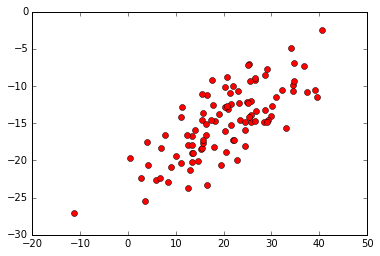

In [23]:
X = [
    [20.9666776351559,-13.1138080189357],
    [22.7719907680008,-19.8890894944696],
    [25.6687103160153,-11.9956004517219],
    [18.0019794950564,-18.1989191165133],
    [21.3967402102156,-10.8893126308196],
    [0.443696899177716,-19.7221132386308],
    [29.9198322142127,-14.0958668502427],
    [19.0805843080126,-13.7888747608312],
    [16.4685063521314,-11.2612927034291],
    [21.4597664701884,-12.4740034586705],
    [3.87655283720532,-17.575162461771],
    [34.5713920556787,-10.705185165378],
    [13.3732115747722,-16.7270274494424],
    [20.7281704141919,-8.81165591556553],
    [24.839851437942,-12.1240962157419],
    [20.3019544741252,-12.8725060780898],
    [21.9021426929599,-17.3225432396452],
    [23.2285885715486,-12.2676568419045],
    [28.5749111681851,-13.2616470619453],
    [29.2957424128701,-14.6299928678996],
    [15.2495527798625,-18.4649714274207],
    [26.5567257400476,-9.19794350561966],
    [30.1934232346361,-12.6272709845971],
    [36.8267446011057,-7.25409849336718],
    [32.157416823084,-10.4729534347553],
    [5.85964365291694,-22.6573731626132],
    [25.7426190674693,-14.8055803854566],
    [16.237602636139,-16.5920595763719],
    [14.7408608850568,-20.0537715298403],
    [6.85907008242544,-18.3965586884781],
    [26.5918329233128,-8.92664811750842],
    [-11.2216019958228,-27.0519081982856],
    [8.93593745011035,-20.8261235122575],
    [24.4481258671796,-18.0324012215159],
    [2.82048515404903,-22.4208457598703],
    [30.8803004755948,-11.455358009593],
    [15.4586738236098,-11.1242825084309],
    [28.5332537090494,-14.7898744423126],
    [40.4830293441052,-2.41946428697183],
    [15.7563759125684,-13.5771266003795],
    [19.3635588851727,-20.6224770470434],
    [13.4212840786467,-19.0238227375766],
    [7.77570680426702,-16.6385739839089],
    [21.4865983854408,-15.290799330002],
    [12.6392705930724,-23.6433305964301],
    [12.4746151388128,-17.9720169566614],
    [23.4572410437998,-14.602080545086],
    [13.6878189833565,-18.9687408182414],
    [15.4077465943441,-14.5352487124086],
    [20.3356581548895,-10.0883159703702],
    [20.7093833689359,-12.6939091236766],
    [11.1032293684441,-14.1383848928755],
    [17.5048321498308,-9.2338593361801],
    [16.3303688220188,-15.1054735529158],
    [26.6929062710726,-13.306030567991],
    [34.4985678099711,-9.86199941278607],
    [39.1374291499406,-10.5621430853401],
    [21.9088956482146,-9.95198845621849],
    [22.2367457578087,-17.2200123442707],
    [10.0032784145577,-19.3557700653426],
    [14.045833906665,-15.871937521131],
    [15.5640911917607,-18.3396956121887],
    [24.4771926581586,-14.8715313479137],
    [26.533415556629,-14.693883922494],
    [12.8722580202544,-21.2750596021509],
    [24.4768291376862,-15.9592080959207],
    [18.2230748567433,-14.6541444069985],
    [4.1902148367447,-20.6144032528762],
    [12.4332594022086,-16.6079789231489],
    [20.5483758651873,-18.8512560786321],
    [17.8180560451358,-12.5451990696752],
    [11.0071081078049,-20.3938092335862],
    [8.30560561422449,-22.9503944138682],
    [33.9857852657284,-4.8371294974382],
    [17.4376502239652,-14.5095976075022],
    [29.0379635148943,-14.8461553663227],
    [29.1344666599319,-7.70862921632672],
    [32.9730697624544,-15.5839178785654],
    [13.4211493998212,-20.150199857584],
    [11.380538260355,-12.8619410359766],
    [28.672631499186,-8.51866271785711],
    [16.4296061111902,-23.3326051279759],
    [25.7168371582585,-13.8899296143829],
    [13.3185154732595,-17.8959160024249],
    [3.60832478605376,-25.4023343597712],
    [39.5445949652652,-11.466377647931],
    [25.1693484426101,-12.2752652925707],
    [25.2884257196471,-7.06710309184533],
    [6.77665715793125,-22.3947299635571],
    [20.1844223778907,-16.0427471125407],
    [25.5506805272535,-9.33856532270204],
    [25.1495682602477,-7.17350567090738],
    [15.6978431006492,-17.5979197162642],
    [37.42780451491,-10.843637288504],
    [22.974620174842,-10.6171162611686],
    [34.6327117468934,-9.26182440487384],
    [34.7042513789061,-6.9630753351114],
    [15.6563953929008,-17.2196961218915],
    [25.2049825789225,-14.1592086208169]
]
np_X= np.array(X)
plt.plot( np_X[:,0], np_X[:,1],"ro")
plt.show()

In [24]:
def de_mean_matrix(A):
    """returns the result of subtracting from every value in A the mean
    value of its column. the resulting matrix has mean 0 in every column"""
    nr, nc = shape(A)
    column_means, _ = scale(A)
    return make_matrix(nr, nc, lambda i, j: A[i][j] - column_means[j])

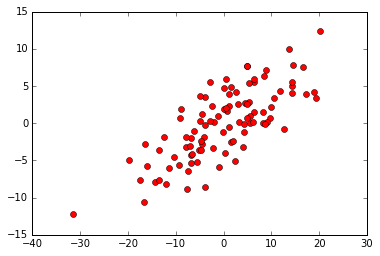

In [25]:
np_mean_X = np.array(de_mean_matrix(X))

plt.plot( np_mean_X[:,0], np_mean_X[:,1],"ro")
plt.show()

In [26]:
def direction(w):
    mag = magnitude(w)
    return [w_i / mag for w_i in w]

def directional_variance_i(x_i, w):
    """the variance of the row x_i in the direction w"""
    return dot(x_i, direction(w)) ** 2

def directional_variance(X, w):
    """the variance of the data in the direction w"""
    return sum(directional_variance_i(x_i, w) for x_i in X)

def directional_variance_gradient_i(x_i, w):
    """the contribution of row x_i to the gradient of
    the direction-w variance"""
    projection_length = dot(x_i, direction(w))
    return [2 * projection_length * x_ij for x_ij in x_i]

def directional_variance_gradient(X, w):
    return vector_sum(directional_variance_gradient_i(x_i,w) for x_i in X)

def first_principal_component(X):
    guess = [1 for _ in X[0]]
    unscaled_maximizer = maximize_batch(
        partial(directional_variance, X),           # is now a function of w
        partial(directional_variance_gradient, X),  # is now a function of w
        guess)
    return direction(unscaled_maximizer)

def first_principal_component_sgd(X):
    guess = [1 for _ in X[0]]
    unscaled_maximizer = maximize_stochastic(
        lambda x, _, w: directional_variance_i(x, w),
        lambda x, _, w: directional_variance_gradient_i(x, w),
        X, [None for _ in X], guess)
    return direction(unscaled_maximizer)

def project(v, w):
    """return the projection of v onto w"""
    coefficient = dot(v, w)
    return scalar_multiply(coefficient, w)

def remove_projection_from_vector(v, w):
    """projects v onto w and subtracts the result from v"""
    return vector_subtract(v, project(v, w))

def remove_projection(X, w):
    """for each row of X
    projects the row onto w, and subtracts the result from the row"""
    return [remove_projection_from_vector(x_i, w) for x_i in X]

def principal_component_analysis(X, num_components):
    components = []
    for _ in range(num_components):
        component = first_principal_component(X)
        components.append(component)
        X = remove_projection(X, component)

    return components

def transform_vector(v, components):
    return [dot(v, w) for w in components]

def transform(X, components):
    return [transform_vector(x_i, components) for x_i in X]

print("PCA")

Y = de_mean_matrix(X)
components = principal_component_analysis(Y, 2)
print("principal components", components)
print("first point", Y[0])
print("first point transformed", transform_vector(Y[0], components))

PCA
principal components [[0.92385540904318986, 0.3827416663777809], [-0.38272245395799814, 0.92386336827280258]]
first point [0.66637087202545686, 1.6869418499129409]
first point transformed [1.2612932692676408, 1.3034686841532084]
